In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
os.sys.path.append('../utils') #To load master_configuration.yaml
from readYAML import read_config_file #To load in master configuration

### Aside: let's begin by setting up our environment by reading master_configuration.yaml

Conf will be used later on when we get into generating images and labels for training YOLO. I've set up this configuration environment so the user doesn't have to find specific notebook cells to edit. Instead, you can just edit master_configuration.yaml. You can feel free to expand master_configuration.yaml as needed.

In [2]:
'''TODO for Jeff: integrate convenience functions like this into the readYAML.py'''

def load_configuration(file_path):
    
    #Read yoloConf field of yaml file
    conf = read_config_file(file_path)['yoloConf']
    
    #Raise error if there's noise because there isn't supposed to be for this tutorial :-)
    if conf['noise'] == True:
        raise ValueError("For this tutorial we will not be working with noisy simulation. Please change the 'noise' field to False in master_configuration.yaml")
    #Check the Ultralytics fields in master_configuration.yaml based on if we're using linear or log scale images
    else:
        if conf['log_scale'] == True:
            Ultconf = read_config_file(file_path)['log_scale']
        else:
            Ultconf = read_config_file(file_path)['linear_scale']
    #Append the correct ultralytics training information to our yolo configuration
    conf.update(Ultconf)
    return conf

In [3]:
conf = load_configuration('../master_configuration.yaml')

In [4]:
'''Conf is a dictionary'''
conf

{'use_pretrained': True,
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'numKeyPoints': 7,
 'GPU': True,
 'project': '../models/raw_linear',
 'yoloConfigFile': '../configs/keypoint.yaml',
 'suffix': ''}

### Okay, now the processing begins. Let's start by loading simulation

In [5]:
'''Load simulated ERs'''
ERs = pd.read_feather('../data/raw_simulation/ERs_cont_spectrum_correctE.feather')

### Now we approximate the head as the point with highest intensity and use the truth simulated vertex as the tail. These are our track endpoints and we will use these as boundaries to define our keypoint training labels

In [6]:
def find_head(df,i):
    tmp = df.iloc[i]
    indices = pd.Series(tmp['q']).nlargest(3).index.to_numpy()
    return np.median(tmp['x'][indices]),np.median(tmp['y'][indices])

In [7]:
xs = []
ys = []
for i in tqdm(range(0,len(ERs))):
    x,y = find_head(ERs,i)
    xs.append(x)
    ys.append(y)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10500/10500 [00:05<00:00, 2056.47it/s]


In [8]:
ERs['xhead'] = xs
ERs['yhead'] = ys

### To keep "nice" ER tracks, we can cut on the distance between the track vertex and track head which I'm calling 'htlength' which is short for head/tail length. 
This isn't something we generally want to do, but I'm doing this so we can automatically generate decent-looking keypoint sets easily. In general we want something that works even for ERs following the most complicated trajectories, but this is just a demonstration

In [9]:
ERs['htlength'] = np.sqrt((ERs['xvtx']-ERs['xhead'])**2+(ERs['yvtx']-ERs['yhead'])**2)

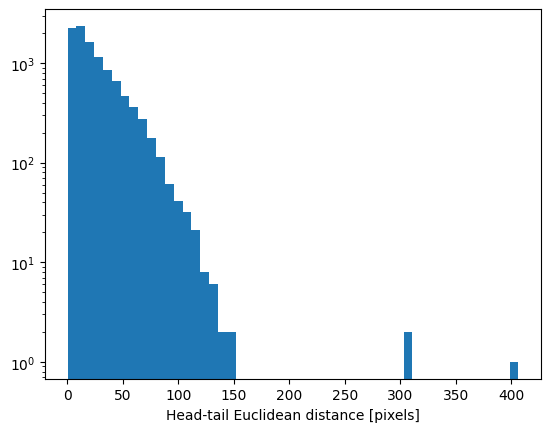

'Most tracks have short head/tail lengths. We"re going to consider longer lengths, \nas trajectories are less ambiguous for these'

In [10]:
'''Whenever you define a new variable that you can make cuts on, it"s generally good practice
to look at the distribution of the variable'''

plt.hist(ERs['htlength'],bins=51)
plt.xlabel('Head-tail Euclidean distance [pixels]')
plt.yscale('log')
plt.show()

'''Most tracks have short head/tail lengths. We"re going to consider longer lengths, 
as trajectories are less ambiguous for these'''

### Centering tracks to make rotations easier. This step isn't strictly necessary but I'm doing it for this example

In [11]:
'''Center all tracks. First shift the vertex and head columns, then do the entire track'''
ERs['xvtx'] = ERs['xvtx']-ERs['x'].apply(lambda x: x.min())+1024
ERs['yvtx'] = ERs['yvtx']-ERs['y'].apply(lambda x: x.min())+1152//2
ERs['xhead'] = ERs['xhead']-ERs['x'].apply(lambda x: x.min())+1024
ERs['yhead'] = ERs['yhead']-ERs['y'].apply(lambda x: x.min())+1152//2

ERs['x'] = ERs['x'].apply(lambda x: x-x.min()+1024)
ERs['y'] = ERs['y'].apply(lambda x: x-x.min()+1152//2)

# This method is what we're using to generate simulated key points.
**These keypoints are what we will use to label our data to train YOLO. Any supervised learning task requires to be trained on labeled data. For this example, I thought it would be better to automate the key point generation, rather than making us label a ton of data by hand.**

You might be wondering, "wait, if we can automatically generate key points, then what's the point of using YOLO?" Well, the point of training YOLO is to come up with a general way of identifying key points. The method we're using here works because (a) we don't have noise to begin with, and most importantly, (b) we know the vertex (tail) of simulated ER tracks. Knowledge of the vertex is needed for the method below to work and in general, the tail of ERs is difficult to find in real data using first principles approaches. So, we'll use this method to generate sets of key points to train YOLO on, then we'll train YOLO, and then we'll test it's predictions on data it wasn't trained on and see how it compares to this method.

In [12]:
import numpy as np
from scipy.sparse import coo_matrix

class generate_keypoints:
    '''Class takes a sparse image, rotates it so the head and tail are vertically aligned.
    Then it partitions the interval between the head and tail into n_outputs + 2 equally spaced subdivisions
    and records the (x',y') coordinate of either (a) the max intensity [if the mode parameter is set to 'max']
    or (b), the median (x',y') over the 9 most intense pixels in each partition. The code then rotates the set of
    (x',y')s back to the original image orientation, which are our keypoints!'''
    
    def __init__(self,df,i,n_outputs=1,dim=(2048,1152),mode='max'):
        if mode.lower() != 'max' and mode.lower() != 'median':
            raise ValueError("mode must be 'max' or 'median'")
        self.mode = mode.lower()
        evt = df.iloc[i]
        self.n_outputs = n_outputs
        self.center_x = dim[1] // 2
        self.center_y = dim[0] // 2
        self.col = evt['x'].astype('int')
        self.row = evt['y'].astype('int')
        self.data = evt['q']
        self.head = np.array([evt['xhead'],evt['yhead']])
        self.tail = np.array([evt['xvtx'],evt['yvtx']])
        self.rotation_angle = self.get_rotation_angle()
        
        '''Rotation matrices, backward rotation is used to translate track segments back to original'''
        self.forward_rotation = self.generate_rotation_matrix(self.rotation_angle)
        self.reverse_rotation = np.linalg.inv(self.forward_rotation)
        
        '''Rotate head and tail to rotated space'''
        self.rothead = self.rotate_coord(self.head[::-1],self.forward_rotation)
        self.rottail = self.rotate_coord(self.tail[::-1],self.forward_rotation)
        
        #print(self.rotate_coord(self.rothead,self.reverse_rotation))
        '''Generate rotated sparse image'''
        self.rot_im = self.rotate_sparse_image()
        
        '''Get segmented coordinates in rotated space'''
        self.rot_segments = np.array(self.get_segment_coordinates()).T
        self.segments = []
        self.segments.append((evt['xvtx'],evt['yvtx']))
        for coord in self.rot_segments:
            self.segments.append(self.rotate_coord(coord,self.reverse_rotation)[::-1])
        self.segments.append((evt['xhead'],evt['yhead']))
    def get_rotation_angle(self):
        vec = np.array([self.head[0]-self.tail[0],self.head[1]-self.tail[1]])
        theta = np.arctan2(vec[1],vec[0])
        return theta

    def generate_rotation_matrix(self,theta):
        cos_angle = np.cos(theta)
        sin_angle = np.sin(theta)
        
        rotation_matrix = np.array([
            [cos_angle, sin_angle],
            [-sin_angle, cos_angle]
        ])
            
        return rotation_matrix

    def rotate_sparse_image(self):
        sparse_matrix = coo_matrix((self.data, (self.row, self.col)), shape=(1152,2048))
        # Center of the image

        # Translate coordinates to origin
        translated_x = self.col - self.center_x
        translated_y = self.row - self.center_y

        # Apply rotation
        new_coords = np.dot(self.forward_rotation, np.array([translated_x, translated_y]))

        new_x = np.round(new_coords[0] + self.center_x).astype('int')
        new_y = np.round(new_coords[1] + self.center_y).astype('int')

        # Filter out-of-bounds coordinates
        valid_mask = (new_x >= 0) & (new_x < sparse_matrix.shape[1]) & (new_y >= 0) & (new_y < sparse_matrix.shape[0])
        new_x = new_x[valid_mask]
        new_y = new_y[valid_mask]
        new_data = self.data[valid_mask]

        # Create the rotated sparse matrix
        rotated_sparse_matrix = coo_matrix((new_data, (new_y, new_x)), shape=sparse_matrix.shape)
        return rotated_sparse_matrix.toarray().T
    
    def rotate_coord(self,coord,rot):
        original_coordinate = coord

        # Translate coordinate to origin
        translated_x = original_coordinate[1] - self.center_x
        translated_y = original_coordinate[0] - self.center_y

        # Apply rotation
        new_coord = np.dot(rot, np.array([translated_x, translated_y]))

        # Translate back to the original coordinate system
        new_coordinate = (new_coord[1] + self.center_y, new_coord[0] + self.center_x)
        return new_coordinate
    
    def get_segment_coordinates(self):
        n_partitions = self.n_outputs+2
        y_segments = np.linspace(self.rottail[1],self.rothead[1],n_partitions)[1:-1]
        x_segments = []
        for seg in y_segments:
            if self.mode == 'max':
                x_coord = np.median(np.where(self.rot_im[int(np.round(seg)),:] == self.rot_im[int(np.round(seg)),:].max())[0])
            elif self.mode == 'median':
                indices = pd.Series(self.rot_im[int(np.round(seg)),:]).nlargest(9).index.to_numpy()
                x_coord = np.median(indices)
            x_segments.append(x_coord)
        x_segments = np.array(x_segments)
        if np.mean(x_segments) != 575.5 and np.mean(x_segments) != 4:
            return x_segments,y_segments
        else:
            raise ValueError("Bad rotation")

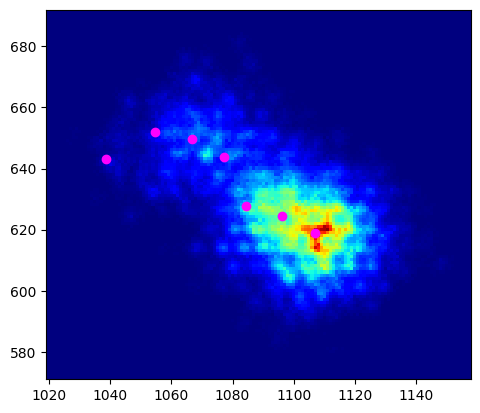

In [13]:
'''Let"s test the output of this method. We"ll run it on one event and then plot the output'''

#We're generating keypoints for track 11 of the set of ERs with htlength > 11
#Remember conf['numKeyPoints'] is the total number of keypoints in our sample which includes the head and tail
#We therefore generate conf['numKeyPoints']-2 points
#Feel free to play around with the n_outputs parameter here but make sure you set the desired number of
#key points in master_configuration.yaml when performing a study
a = generate_keypoints(ERs.query('htlength > 50'),i = 11,n_outputs = conf['numKeyPoints']-2,mode = 'median') #can change 'median' to 'max' to test what happens

'''Our simulation has track coordinates stored as sparse arrays, meaning it only saves the coordinates
of pixels with non-zero content. To form images our of sparse arrays you can just histogram the sparse
array content, setting the bins and range to be appropriate for the camera'''
im = np.histogram2d(a.col,a.row,weights=a.data,bins=(2048,1152),range=((0,2048),(0,1152)))[0].T

#plot image
plt.imshow(im,cmap='jet')
#Zoom into track
plt.xlim(a.col.min()-5,a.col.max()+5)
plt.ylim(a.row.min()-5,a.row.max()+5)

#Plot segments we generated
for seg in a.segments: #a.segments are the output of generate_keypoints
    plt.plot(seg[0],seg[1],'o',color='magenta')

plt.xlim()
plt.show()

### Now let's process all events with 50 < htlength < 200. This cut gives us the longer ER tracks but omits the exceptionally long outliers we saw in the previous histogram

In [14]:
'''There"s an apparent bug in the keypoint generation code where certain kinds of rotations mess things up.
I"ve figured out how to flag these, but haven"t figured out how to fix this. Nevertheless, since this is
meant to be a minimal working example, we won"t sweat this. Because of this bug, there will be a preferred 
direction in the trajectories that do generate. Generally speaking training on a preferred direction will 
bias a machine learning model which we don"t want.'''

ERs = ERs.query('200 > htlength > 50')
ERs.index = [i for i in range(0,len(ERs))]

good_indices = []
coords = {} #dictionary filled with keypoint tuples
for i in range(0,len(a.segments)):
    coords[i] = []

for i in tqdm(range(0,len(ERs))):
    try:
        a = generate_keypoints(ERs,i,n_outputs=conf['numKeyPoints']-2,mode='median')
        good_indices.append(i)
        for j in range(0,len(a.segments)):
            coords[j].append(a.segments[j])
    except:
        #print("Bad rotation")
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1437/1437 [00:04<00:00, 343.66it/s]


In [15]:
'''Reduce our dataframe to only include entries where the trajectory generated'''
ERs = ERs.loc[ERs.index.isin(good_indices)] #only keep the events where the loop above didnt fail
ERs.index = [i for i in range(0,len(ERs))]

### Now we need to format our data consistent with what YOLOv8 requires. We use the format with dim = 2 from https://docs.ultralytics.com/datasets/pose/#supported-dataset-formats shown below

class-index, x, y, width, height, px1, py1, px2, py2,...,pxn, pyn

Where

**class_index**: 0 (choice is up to us but this is what I use for ERs)\
**xBB**: x coordinate of the center of the bounding box (BB) surrounding the track\
**yBB**: y coordinate of the center of the bounding box surrounding the track\
**width**: width of the bounding box\
**height**: height of the bounding box\
**pxN**: x coordinate of the Nth key point. **Key points should be ordered so we'll get head/tail out of the box!** \
**pyN**: y coordinate of the Nth key point. **Key points should be ordered so we'll get head/tail out of the box!**

In [16]:
'''Whenever I"m processing data, I like to check the columns in my dataframe periodically'''
ERs.columns

Index(['x', 'y', 'q', 'xvtx', 'yvtx', 'E', 'theta', 'phi', 'phid', 'thetad',
       'xhead', 'yhead', 'htlength'],
      dtype='object')

In [17]:
'''Make class_index, x, y, width, and height columns'''

ERs['class_index'] = 0

'''Columns "x", "y", and "q" are array-based quantities. We can use pandas"s apply function and
lambda expressions to do array operations rowwise in a succinct way. Don"t worry if this notation
seems cryptic, once you get used to it, it"s very succinct and efficient for array operations
in pandas dataframes'''

ERs['xBB'] = ERs['x'].apply(lambda x: (x.max()+x.min())/2 / conf['cameraX']) #normalized as a fraction of width of image (2048 pixels)
ERs['yBB'] = ERs['y'].apply(lambda x: (x.max()+x.min())/2 / conf['cameraY']) #normalized as a fraction of height of image (1152 pixels)
ERs['width'] = ERs['x'].apply(lambda x: (x.max()-x.min()) / conf['cameraX'])
ERs['height'] = ERs['y'].apply(lambda x: (x.max()-x.min()) / conf['cameraY'])

In [18]:
'''Notice the configuration variables in these expressions. Let"s remind ourselves of the contents of
our configuration file'''
conf

{'use_pretrained': True,
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'numKeyPoints': 7,
 'GPU': True,
 'project': '../models/raw_linear',
 'yoloConfigFile': '../configs/keypoint.yaml',
 'suffix': ''}

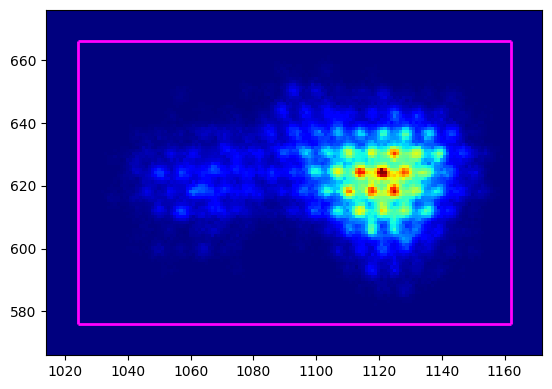

In [19]:
'''Lets plot a test image with a bounding box to test that we did it right'''
index = 15
tmp = ERs.iloc[index] #we'll plot frame 8
im = np.histogram2d(tmp['x'],tmp['y'],weights=tmp['q'],bins=(conf['cameraX'],conf['cameraY']),range=((0,conf['cameraX']),(0,conf['cameraY'])))[0].T
plt.imshow(im,cmap='jet')
plt.xlim(tmp['x'].min()-10,tmp['x'].max()+10)
plt.ylim(tmp['y'].min()-10,tmp['y'].max()+10)
xmin = (tmp['xBB']-tmp['width']/2)*conf['cameraX']
xmax = (tmp['xBB']+tmp['width']/2)*conf['cameraX']
ymin = (tmp['yBB']-tmp['height']/2)*conf['cameraY']
ymax = (tmp['yBB']+tmp['height']/2)*conf['cameraY']
plt.hlines(ymin,xmin,xmax,color='magenta',lw=2)
plt.hlines(ymax,xmin,xmax,color='magenta',lw=2)
plt.vlines(xmin,ymin,ymax,color='magenta',lw=2)
plt.vlines(xmax,ymin,ymax,color='magenta',lw=2)

### A reminder in case it isn't clear: the reason why we are able to generate bounding boxes like this is because we know the true boundaries of simulated tracks! This allows us to generate all labels automatically so we can train YOLO without hand labeling data

Now we will put our generated keypoints into the dataframe

In [20]:
'''Puts key point tuples into into columns p0 to pN'''
for key in coords.keys():
    ERs['p%s'%(key)] = coords[key]

In [21]:
'''Expands the tuples to p0x, p0y, p1x, p1y, etc.'''
# Initialize an empty dictionary to hold the new columns
new_columns = {}

# Iterate over each of the keypoint columns in the DataFrame
for col in ERs.columns[int(-1*conf['numKeyPoints']):]: #apologies that this is
    # Extract x and y components from each column
    ERs[[f'{col}x', f'{col}y']] = pd.DataFrame(ERs[col].tolist(), index=ERs.index)
    # Drop the original column
    ERs.drop(columns=[col], inplace=True)

### Don't forget to normalize the keypoints too!

In [22]:
for i in range(0,conf['numKeyPoints']):
    ERs['p%sx'%(i)] = ERs['p%sx'%(i)]/conf['cameraX']
    ERs['p%sy'%(i)] = ERs['p%sy'%(i)]/conf['cameraY']

In [23]:
'''Check the columns of our dataframe'''
ERs.columns

Index(['x', 'y', 'q', 'xvtx', 'yvtx', 'E', 'theta', 'phi', 'phid', 'thetad',
       'xhead', 'yhead', 'htlength', 'class_index', 'xBB', 'yBB', 'width',
       'height', 'p0x', 'p0y', 'p1x', 'p1y', 'p2x', 'p2y', 'p3x', 'p3y', 'p4x',
       'p4y', 'p5x', 'p5y', 'p6x', 'p6y'],
      dtype='object')

### Now let's generate image and label files for our training, validation, and test sets

### Step 0: Determine train / validation / test split. We're going to do this in the most rudimentary way. Scikit learn has a lot of information about good ways to do this that are worth looking up when you have the time. Here are a few examples:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

https://machinelearningmastery.com/k-fold-cross-validation/

In [24]:
'''I"m manually splitting the data up into 70% train, 20% validation, 10% test. There are better and more
statistically robust ways of doing this, like using k-fold cross validation which I linked an article on
above. You also ALWAYS want to shuffle your data before splitting it up. A lot of scikit-learn"s convenience
functions automatically shuffle for you but we"ll do it manually here'''

dataset_size = len(ERs)
# Shuffle data
ERs = ERs.sample(frac=1,random_state=42) #Random state ensures we get identical shuffles every time for reproducability
ERs.index = [i for i in range(0,len(ERs))] #reset index after shuffling
ERs['index'] = ERs.index
data = {} #dictionary storing train, validation, and test datasets
data['train'] = ERs[:int(dataset_size*0.7)]
data['valid'] = ERs[int(dataset_size*0.7):int(dataset_size*0.9)]
data['test'] =  ERs[int(dataset_size*0.9):]
print('Train set size: %s\nval set size : %s\ntest set size: %s\nsum : %s\ndataset size: %s'%(len(data['train']),len(data['valid']),len(data['test']),len(data['train'])+len(data['valid'])+len(data['test']),dataset_size))

Train set size: 782
val set size : 224
test set size: 112
sum : 1118
dataset size: 1118


### Step 1: Generate images. The reason why we normalize the bounding box and key point coordinates is so YOLO can be scale invariant. Scale invariance means that we can downsample an image by a uniform scale factor and the labels associated with this scaling will still be valid

Let's generate 4 x 4 images. This will reduce computational and memory expense by a factor of 16

In [25]:
conf

{'use_pretrained': True,
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'numKeyPoints': 7,
 'GPU': True,
 'project': '../models/raw_linear',
 'yoloConfigFile': '../configs/keypoint.yaml',
 'suffix': ''}

In [26]:
import matplotlib.image
def save_images(settype):
    
    if settype.lower() != 'train' and settype.lower() != 'test' and settype.lower() !='valid':
        raise ValueError("settype must be 'train','valid',or 'test'")
    
    path = '../datasets/%s%s/images'%(settype.lower(),conf['suffix'])
    
    #Create our output directory if it doesn't already exist
    if not os.path.exists(path):
        os.makedirs(path)
    
    for i in tqdm(range(0,len(data[settype.lower()]))):
        
        tmp = data[settype.lower()].iloc[i]
        
        '''Setting bins to (512,288) downsamples the image with 4x4 binning'''
        im = np.histogram2d(tmp['x'],tmp['y'],weights=tmp['q'],bins=(512,288),range=((0,2048),(0,1152)))[0].T
        
        '''The colorscale (vmin and vmax) as well as how we define im depend on if we use linear or logarithmic
        colorscale images'''
        if conf['log_scale'] == False:
            matplotlib.image.imsave('%s/%s.png'%(path,tmp['index']), im, vmin=0, vmax=35000,cmap = 'jet')
        else:
            im = np.log10(im+1)
            matplotlib.image.imsave('%s/%s.png'%(path,tmp['index']), im, vmin=0, vmax=4,cmap = 'jet')

In [27]:
'''Recall that master_configuration.yaml tells us if we"re using a log colorscale or not. This is built into the 
save_images function so the user doesn"t have to declare it here'''
for key in ['train','valid','test']:
    save_images(key)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 173.87it/s]


### Step 2: Generate labels

In [28]:
'''Ditto here: whether or not we use a log scale is determined from master_configuration.yaml'''
def save_labels(settype):
    if settype.lower() != 'train' and settype.lower() != 'test' and settype.lower() !='valid':
        raise ValueError("settype must be 'train','valid',or 'test'")

    path = '../datasets/%s%s/labels/'%(settype.lower(),conf['suffix'])
    
    if not os.path.exists(path):
        os.makedirs(path)

    for i in range(0,len(data[settype.lower()])):
        tmp = data[settype.lower()].iloc[i]
        series = tmp[['class_index','xBB', 'yBB', 'width','height', 'p0x', 'p0y', 'p1x', 'p1y', 'p2x', 'p2y', 'p3x', 'p3y', 'p4x','p4y', 'p5x', 'p5y', 'p6x', 'p6y']]
        with open(path+'%s.txt'%(tmp['index']), 'w') as f:
            series_str = ' '.join(map(str, series.values))
            f.write(series_str + '\n')
            f.close()

In [29]:
for key in ['train','valid']:
    save_labels(key)

### Step 3: Save our train, validation, and test dataframes for usage later

In [30]:
# Need to reset indices in order to save as feather
for key in ['train','valid','test']:
    data[key].index = [i for i in range(0,len(data[key]))]
    data[key].to_feather("../data/%s%s.feather"%(key,conf['suffix']))

# Now lets train YOLO (training will take a while. If you don't have access to a GPU, I would recommend leaving this script running overnight, or sending your data to Jeff so he can train it on a GPU)

In [31]:
conf

{'use_pretrained': True,
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'numKeyPoints': 7,
 'GPU': True,
 'project': '../models/raw_linear',
 'yoloConfigFile': '../configs/keypoint.yaml',
 'suffix': ''}

In [32]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8m-pose.yaml')  # load empty model. Can choose from yolov8{n,s,m,l,x}-pose.yaml. Letters are ordered from smallest model to largest
        
'''There are a lot of arguments for the train function that are not used here, so it may
be worth looking up some of the other options in the Ultralytics documentation for the 
train() function. master_configuration.yaml should handle some of these arguments pretty smoothly
but nevertheless, here are brief descriptions of the ones used here

data: A .yaml configuration file that lists important details of our keypoint data format and which
directories YOLO should extract images and labels from. You can view this file with your favorite text editor

epochs: Number of times the training script will loop over the entire dataset. It first loops through the
training set and then evaluates on the validation set. The validation metrics are what we use to determine
how well the model performs as its being trained. This is because the model isn"t trained on the validation set.

imgsz: The size of the maximum width of the image. We downsampled using 4 x 4 binning, thereby reducing the
2048 x 1152 images to 512 x 288.

rect: Setting this to true tells YOLO that these aren't square images and that it needs to measure the smaller
dimension scaled to the 512 we put in imgsz (this means it will automatically detect 288 pixels in y)

patience: This is an important training parameter more commonly called "early stopping" in ML parlance.
patience = 25 means that the algorithm will train until 25 successive epochs have elapsed where the model
didn't improve in a predefined metric (here its the average precision metric). In other words, if the model
didn"t "improve its learning on the validation set" after 25 epochs then it will terminate training. This is important to avoid
overtraining models.

device: Whether we train on CPU or GPU. Leave this field empty for now
'''

#Function to train YOLO
#The project field sets the directory where YOLO's trained weights will be assigned
model.train(data=conf['yoloConfigFile'],project=conf['project'],epochs=1000,patience=25,imgsz=512,rect=True)


New https://pypi.org/project/ultralytics/8.2.18 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.8 🚀 Python-3.10.10 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)
engine/trainer: task=pose, mode=train, model=yolov8m-pose.yaml, data=../configs/keypoint.yaml, epochs=1000, time=None, patience=25, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=../models/raw_linear, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=True, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False

train: Scanning /home/jeef/workspace/Migdal_backup/keyPoint_tutorial/datasets/train/labels... 782 images, 0 backgrounds, 2 corrupt: 100%|██████████| 782/782 [00:00<00:00, 2817.98it/s]

train: WARNING ⚠️ /home/jeef/workspace/Migdal_backup/keyPoint_tutorial/datasets/train/images/291.png: ignoring corrupt image/label: negative label values [  -0.065833   -0.073148   -0.080463]
train: WARNING ⚠️ /home/jeef/workspace/Migdal_backup/keyPoint_tutorial/datasets/train/images/730.png: ignoring corrupt image/label: negative label values [  -0.073238   -0.082072   -0.090905]
train: New cache created: /home/jeef/workspace/Migdal_backup/keyPoint_tutorial/datasets/train/labels.cache
WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'


WARNING ⚠️ 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False


val: Scanning /home/jeef/workspace/Migdal_backup/keyPoint_tutorial/datasets/valid/labels... 224 images, 0 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<00:00, 1859.98it/s]

val: New cache created: /home/jeef/workspace/Migdal_backup/keyPoint_tutorial/datasets/valid/labels.cache


Plotting labels to ../models/raw_linear/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 83 weight(decay=0.0), 93 weight(decay=0.0005), 92 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to ../models/raw_linear/train
Starting training for 1000 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     1/1000      2.79G      6.553        7.9          0      10.82      4.527         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        224        224          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     2/1000      2.76G       4.39      5.375          0      5.312      3.228         12        512: 100%|██████████| 49/49 [00:06<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        224        224          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     3/1000      2.77G      2.744      3.826          0      2.469      2.059         12        512: 100%|██████████| 49/49 [00:06<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        224        224      0.817      0.857      0.896      0.337      0.753      0.789      0.794      0.311



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     4/1000      2.77G      2.292      2.766          0      1.826       1.73         12        512: 100%|██████████| 49/49 [00:06<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]

                   all        224        224      0.871      0.973      0.978      0.447      0.855      0.955      0.951      0.477



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     5/1000      2.76G      2.005      1.928          0      1.172      1.518         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        224        224      0.907      0.978      0.977      0.426      0.899      0.969      0.965      0.643



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     6/1000      2.76G      1.779      1.546          0     0.9472      1.335         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

                   all        224        224      0.951      0.955       0.97      0.422       0.96      0.962      0.982      0.691



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     7/1000      2.77G      1.531       1.21          0     0.8382      1.216         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all        224        224      0.961          1      0.993       0.63      0.952      0.991      0.991      0.774



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     8/1000      2.75G      1.382      1.178          0     0.7481      1.133         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]

                   all        224        224      0.991          1      0.995      0.619      0.982      0.991      0.993      0.753



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     9/1000      2.75G      1.337     0.9719          0     0.7058       1.08         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]

                   all        224        224      0.974      0.999      0.994      0.584      0.974      0.999      0.994      0.827



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    10/1000      2.75G      1.254     0.8399          0      0.674      1.077         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.24it/s]

                   all        224        224          1          1      0.995      0.659          1          1      0.995      0.832



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    11/1000      2.77G      1.247     0.7805          0     0.6556      1.048         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.26it/s]

                   all        224        224          1          1      0.995      0.649          1          1      0.995      0.838



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    12/1000      2.76G      1.171     0.7246          0     0.6137      1.027         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]

                   all        224        224      0.999          1      0.995      0.653      0.994      0.996      0.992       0.77



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    13/1000      2.76G      1.074     0.7178          0     0.5618     0.9855         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]

                   all        224        224          1          1      0.995       0.64          1          1      0.995      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    14/1000      2.76G      1.084     0.6551          0     0.5552     0.9804         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]

                   all        224        224          1          1      0.995      0.702          1          1      0.995      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    15/1000      2.77G      1.053     0.6309          0     0.5287     0.9733         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all        224        224          1          1      0.995      0.703          1          1      0.995      0.868



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    16/1000      2.76G      1.013     0.6082          0     0.5203     0.9594         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.00it/s]

                   all        224        224      0.999          1      0.995      0.751      0.999          1      0.995      0.868



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    17/1000      2.76G     0.9964     0.6174          0     0.5178      0.955         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.36it/s]

                   all        224        224          1          1      0.995      0.753          1          1      0.995      0.871



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    18/1000      2.76G     0.9789     0.5769          0     0.5136     0.9567         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]

                   all        224        224          1          1      0.995      0.753          1          1      0.995      0.871



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    19/1000      2.77G     0.9616       0.58          0     0.4899     0.9296         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.34it/s]

                   all        224        224      0.105     0.0134    0.00247   0.000247       0.69      0.288      0.419      0.144



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    20/1000      2.76G     0.9317     0.5537          0     0.4671     0.9254         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all        224        224          1          1      0.995      0.776          1          1      0.995      0.901



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    21/1000      2.76G     0.9253     0.5726          0     0.4769      0.933         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]

                   all        224        224      0.999          1      0.995      0.791      0.999          1      0.995      0.884



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    22/1000      2.75G     0.9295     0.5541          0     0.4789     0.9215         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]

                   all        224        224      0.997          1      0.995      0.746      0.997          1      0.995      0.904



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    23/1000      2.76G     0.9057     0.5149          0     0.4646     0.9142         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]

                   all        224        224          1          1      0.995      0.696          1          1      0.995      0.889



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    24/1000      2.75G     0.9021     0.5221          0     0.4646     0.9211         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

                   all        224        224          1          1      0.995      0.773      0.995      0.996      0.993      0.888



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    25/1000      2.76G     0.8719      0.524          0     0.4553     0.9164         12        512: 100%|██████████| 49/49 [00:06<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]

                   all        224        224          1          1      0.995      0.809          1          1      0.995      0.902



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    26/1000      2.76G     0.8614     0.4932          0     0.4431     0.9089         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all        224        224          1          1      0.995      0.778      0.995      0.996      0.994      0.902



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    27/1000      2.77G     0.8461     0.5072          0     0.4325        0.9         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]

                   all        224        224          1          1      0.995      0.736          1          1      0.995      0.881



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    28/1000      2.76G     0.8551     0.4736          0     0.4374     0.9001         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        224        224          1          1      0.995      0.792      0.995      0.996      0.993      0.908



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    29/1000      2.76G     0.8214     0.4767          0     0.4325     0.8898         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        224        224          1          1      0.995      0.795      0.995      0.996      0.994      0.917



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    30/1000      2.76G     0.8077     0.4923          0     0.4186     0.8939         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        224        224      0.999          1      0.995      0.803      0.995      0.996      0.992      0.905



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    31/1000      2.77G     0.8042     0.4869          0     0.4125     0.8883         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

                   all        224        224      0.998          1      0.995      0.766      0.994      0.996      0.991      0.907



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    32/1000      2.77G     0.8103     0.4504          0     0.4086     0.8908         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        224        224          1          1      0.995       0.75      0.995      0.996      0.995      0.897



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    33/1000      2.76G     0.7965     0.4649          0     0.4136     0.8825         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        224        224          1          1      0.995      0.814          1          1      0.995      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    34/1000      2.76G     0.7997     0.4609          0     0.4073     0.8798         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]

                   all        224        224          1          1      0.995      0.765      0.995      0.996      0.994      0.921



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    35/1000      2.77G     0.7701     0.4347          0     0.4069     0.8805         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all        224        224          1          1      0.995      0.804          1          1      0.995      0.914



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    36/1000      2.75G     0.7732     0.4699          0     0.3986     0.8871         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all        224        224          1          1      0.995      0.813          1          1      0.995      0.914



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    37/1000      2.76G     0.7954     0.4985          0     0.4015     0.8884         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]

                   all        224        224      0.995          1      0.995      0.766      0.991      0.996      0.995       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    38/1000      2.76G     0.7708     0.5029          0     0.4019     0.8751         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]

                   all        224        224          1          1      0.995      0.805      0.995      0.996      0.995      0.915



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    39/1000      2.77G     0.7758     0.4918          0      0.406      0.867         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        224        224          1          1      0.995      0.754      0.995      0.996      0.995      0.902



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    40/1000      2.76G     0.7754     0.4693          0     0.3969     0.8774         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.37it/s]

                   all        224        224          1          1      0.995      0.807          1          1      0.995      0.905



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    41/1000      2.76G     0.7706     0.4828          0     0.4029     0.8752         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        224        224          1          1      0.995       0.81      0.995      0.996      0.994      0.916



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    42/1000      2.76G     0.7597     0.4628          0     0.3882     0.8725         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]

                   all        224        224          1          1      0.995      0.821      0.995      0.996      0.995      0.917



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    43/1000      2.76G      0.769     0.4245          0     0.3876     0.8794         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]

                   all        224        224          1          1      0.995      0.812      0.995      0.996      0.994      0.928



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    44/1000      2.76G     0.7557     0.4376          0     0.3914     0.8681         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]

                   all        224        224      0.999          1      0.995      0.813      0.995      0.996      0.994      0.924



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    45/1000      2.76G     0.7764     0.4623          0     0.4026     0.8846         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]

                   all        224        224          1          1      0.995       0.82      0.995      0.996      0.994      0.932



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    46/1000      2.76G     0.7522      0.416          0     0.3712     0.8713         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.00it/s]

                   all        224        224      0.999          1      0.995      0.823      0.994      0.996      0.994      0.925



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    47/1000      2.77G     0.7551     0.3917          0     0.3959     0.8724         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]

                   all        224        224          1          1      0.995      0.768      0.995      0.996      0.994       0.91



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    48/1000      2.76G     0.7516     0.4062          0     0.3806     0.8778         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all        224        224          1          1      0.995      0.818          1          1      0.995      0.926



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    49/1000      2.76G     0.7418     0.3912          0     0.3706     0.8623         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]

                   all        224        224          1          1      0.995      0.806      0.995      0.996      0.993      0.937



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    50/1000      2.76G     0.7305     0.3802          0      0.383     0.8611         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

                   all        224        224          1          1      0.995      0.824      0.995      0.996      0.995      0.933



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    51/1000      2.77G      0.728     0.3907          0       0.37     0.8641         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]

                   all        224        224          1          1      0.995       0.81          1          1      0.995      0.934



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    52/1000      2.76G     0.7196     0.3937          0     0.3624     0.8617         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

                   all        224        224          1          1      0.995      0.814          1          1      0.995      0.929



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    53/1000      2.75G     0.7359     0.3887          0     0.3702     0.8642         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]

                   all        224        224      0.999          1      0.995      0.832      0.995      0.996      0.995      0.931



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    54/1000      2.75G     0.7329     0.3706          0     0.3716     0.8677         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]

                   all        224        224          1          1      0.995       0.82          1          1      0.995      0.937



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    55/1000      2.77G     0.7175     0.3824          0     0.3665     0.8643         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]

                   all        224        224          1          1      0.995      0.817      0.995      0.996      0.994      0.934



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    56/1000      2.75G     0.7182     0.3666          0      0.362     0.8491         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]

                   all        224        224      0.999          1      0.995      0.761      0.999          1      0.995      0.923



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    57/1000      2.75G     0.7037      0.383          0     0.3606     0.8526         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        224        224      0.999          1      0.995      0.812      0.995      0.996      0.994      0.923



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    58/1000      2.75G     0.7273     0.3482          0     0.3673     0.8618         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        224        224      0.999          1      0.995       0.83      0.999          1      0.995      0.931



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    59/1000      2.77G     0.7189     0.3672          0     0.3647     0.8594         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        224        224      0.998          1      0.995      0.809      0.998          1      0.995      0.917



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    60/1000      2.76G     0.7115     0.3534          0     0.3579     0.8586         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        224        224          1          1      0.995      0.837          1          1      0.995      0.935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    61/1000      2.76G     0.7082     0.3656          0     0.3646     0.8594         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]

                   all        224        224          1          1      0.995      0.827          1          1      0.995      0.939



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    62/1000      2.76G     0.7276     0.3547          0     0.3622     0.8456         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]

                   all        224        224          1          1      0.995      0.818          1          1      0.995      0.937



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    63/1000      2.77G     0.7041      0.349          0     0.3581     0.8587         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]

                   all        224        224          1          1      0.995      0.816          1          1      0.995      0.939



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    64/1000      2.76G     0.7079     0.3526          0     0.3589     0.8686         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        224        224          1          1      0.995      0.825          1          1      0.995      0.937



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    65/1000      2.76G     0.7174     0.3476          0      0.352     0.8535         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

                   all        224        224          1          1      0.995      0.831          1          1      0.995      0.924



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    66/1000      2.76G     0.6918     0.3361          0     0.3428     0.8548         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        224        224          1          1      0.995      0.824          1          1      0.995      0.937



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    67/1000      2.77G     0.6916     0.3243          0     0.3445     0.8486         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]

                   all        224        224          1          1      0.995      0.822          1          1      0.995      0.943



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    68/1000      2.76G     0.6909     0.3432          0     0.3416     0.8531         12        512: 100%|██████████| 49/49 [00:06<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        224        224          1          1      0.995      0.835          1          1      0.995      0.922



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    69/1000      2.76G     0.6822     0.3484          0     0.3506     0.8425         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        224        224          1          1      0.995      0.839      0.995      0.996      0.994      0.925



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    70/1000      2.75G     0.6982     0.3442          0     0.3488      0.851         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]

                   all        224        224          1          1      0.995      0.826      0.995      0.996      0.994      0.934



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    71/1000      2.77G     0.7055     0.3347          0     0.3528     0.8512         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all        224        224          1          1      0.995      0.826      0.995      0.996      0.994       0.94



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    72/1000      2.75G     0.6839      0.331          0     0.3387     0.8613         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        224        224          1          1      0.995      0.837          1          1      0.995       0.93



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    73/1000      2.76G     0.6856     0.3438          0     0.3429     0.8605         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        224        224          1          1      0.995      0.832      0.995      0.996      0.995      0.933



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    74/1000      2.76G     0.6957     0.3307          0     0.3484     0.8567         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

                   all        224        224          1          1      0.995      0.842          1          1      0.995       0.94



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    75/1000      2.77G     0.6836     0.3279          0     0.3486      0.862         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]

                   all        224        224          1          1      0.995      0.824          1          1      0.995      0.938



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    76/1000      2.76G     0.6855     0.3196          0     0.3445     0.8567         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]

                   all        224        224          1          1      0.995       0.85          1          1      0.995      0.936



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    77/1000      2.76G     0.6869     0.3273          0     0.3443     0.8514         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.98it/s]

                   all        224        224          1          1      0.995      0.831      0.996      0.996      0.995      0.932



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    78/1000      2.76G     0.6823      0.321          0     0.3426     0.8487         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.36it/s]

                   all        224        224          1          1      0.995      0.842          1          1      0.995      0.935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    79/1000      2.76G     0.6868     0.3229          0     0.3413      0.851         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]

                   all        224        224          1          1      0.995      0.819      0.996      0.996      0.995      0.936



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    80/1000      2.75G     0.6686     0.3104          0       0.33     0.8529         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        224        224          1          1      0.995       0.84          1          1      0.995      0.942



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    81/1000      2.76G     0.6846     0.3113          0     0.3439     0.8519         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        224        224          1          1      0.995      0.838          1          1      0.995      0.933



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    82/1000      2.76G     0.6793     0.2923          0     0.3346     0.8469         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all        224        224          1          1      0.995      0.836          1          1      0.995      0.926



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    83/1000      2.77G     0.6713     0.3109          0     0.3377     0.8441         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.37it/s]

                   all        224        224          1          1      0.995       0.84      0.995      0.996      0.992      0.922



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    84/1000      2.76G     0.6676     0.3098          0     0.3347      0.851         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.37it/s]

                   all        224        224          1          1      0.995      0.831      0.995      0.996      0.993       0.94



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    85/1000      2.76G     0.6784     0.3118          0     0.3369     0.8431         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]

                   all        224        224          1          1      0.995      0.836      0.995      0.996      0.993      0.936



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    86/1000      2.75G     0.6597     0.3077          0     0.3362     0.8465         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

                   all        224        224          1          1      0.995      0.842      0.995      0.996      0.992      0.932



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    87/1000      2.76G     0.6655     0.2921          0     0.3359     0.8431         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

                   all        224        224          1          1      0.995      0.836          1          1      0.995      0.941



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    88/1000      2.76G     0.6595     0.3009          0     0.3249      0.851         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]

                   all        224        224          1          1      0.995      0.843          1          1      0.995      0.941



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    89/1000      2.76G       0.68     0.3126          0     0.3336     0.8479         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        224        224          1          1      0.995      0.824          1          1      0.995      0.925



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    90/1000      2.76G     0.6709     0.3021          0     0.3397     0.8479         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        224        224          1          1      0.995      0.854          1          1      0.995      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    91/1000      2.77G     0.6572     0.2941          0     0.3253     0.8471         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]

                   all        224        224          1          1      0.995      0.848      0.995      0.996      0.993      0.941



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    92/1000      2.76G     0.6529      0.319          0     0.3229     0.8397         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]

                   all        224        224          1          1      0.995       0.84          1          1      0.995      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    93/1000      2.76G     0.6545     0.3024          0     0.3242     0.8413         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

                   all        224        224          1          1      0.995      0.827          1          1      0.995      0.937



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    94/1000      2.76G     0.6476     0.3003          0     0.3222     0.8415         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]

                   all        224        224          1          1      0.995      0.848      0.995      0.996      0.994      0.933



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    95/1000      2.77G     0.6557     0.3134          0     0.3222     0.8385         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]

                   all        224        224          1          1      0.995      0.826          1          1      0.995      0.938



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    96/1000      2.75G     0.6456     0.2791          0     0.3234     0.8422         12        512: 100%|██████████| 49/49 [00:07<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

                   all        224        224          1          1      0.995      0.835          1          1      0.995      0.942



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    97/1000      2.76G      0.646     0.3104          0     0.3229     0.8485         12        512: 100%|██████████| 49/49 [00:05<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]

                   all        224        224          1          1      0.995      0.835          1          1      0.995      0.939



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    98/1000      2.75G     0.6369     0.2951          0     0.3177     0.8409         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]

                   all        224        224          1          1      0.995      0.849          1          1      0.995      0.929



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    99/1000      2.77G     0.6475     0.2825          0     0.3239     0.8499         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.55it/s]

                   all        224        224          1          1      0.995      0.827          1          1      0.995      0.934



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   100/1000      2.76G     0.6355     0.2896          0      0.316     0.8571         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.52it/s]

                   all        224        224          1          1      0.995      0.851          1          1      0.995      0.947



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   101/1000      2.76G     0.6573     0.2959          0     0.3266     0.8521         12        512: 100%|██████████| 49/49 [00:04<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]

                   all        224        224          1          1      0.995      0.843          1          1      0.995      0.937



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   102/1000      2.76G     0.6472     0.2871          0     0.3252     0.8386         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

                   all        224        224          1          1      0.995      0.826          1          1      0.995      0.937



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   103/1000      2.77G     0.6492     0.2865          0      0.326     0.8524         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.54it/s]

                   all        224        224          1          1      0.995      0.837          1          1      0.995       0.94



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   104/1000      2.76G     0.6434     0.2815          0     0.3215     0.8441         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]

                   all        224        224          1          1      0.995      0.833      0.995      0.996      0.993      0.934



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   105/1000      2.76G     0.6463     0.2845          0     0.3261     0.8345         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.55it/s]

                   all        224        224          1          1      0.995      0.842          1          1      0.995      0.928



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   106/1000      2.76G     0.6421     0.2726          0     0.3146      0.828         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.40it/s]

                   all        224        224          1          1      0.995      0.833      0.995      0.996      0.994      0.926



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   107/1000      2.76G     0.6494      0.275          0     0.3146     0.8392         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.56it/s]

                   all        224        224          1          1      0.995      0.846      0.995      0.996      0.992      0.934



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   108/1000      2.76G     0.6334      0.305          0     0.3142      0.834         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]

                   all        224        224          1          1      0.995      0.832      0.995      0.996      0.994       0.93



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   109/1000      2.76G     0.6441     0.2907          0     0.3148     0.8372         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]

                   all        224        224          1          1      0.995      0.831      0.995      0.996      0.995      0.933



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   110/1000      2.76G     0.6334     0.2841          0     0.3126     0.8366         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.27it/s]

                   all        224        224          1          1      0.995      0.849          1          1      0.995      0.934



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   111/1000      2.76G     0.6295     0.2754          0     0.3137     0.8467         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.54it/s]

                   all        224        224          1          1      0.995      0.843          1          1      0.995       0.94



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   112/1000      2.76G      0.631      0.289          0     0.3186     0.8363         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]

                   all        224        224          1          1      0.995      0.847          1          1      0.995      0.939



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   113/1000      2.76G     0.6343     0.2673          0     0.3194     0.8373         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]

                   all        224        224          1          1      0.995      0.843          1          1      0.995      0.932



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   114/1000      2.76G     0.6322     0.2735          0     0.3113     0.8418         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.51it/s]

                   all        224        224          1          1      0.995      0.853      0.996      0.996      0.993      0.935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   115/1000      2.77G     0.6324     0.2843          0     0.3145      0.844         12        512: 100%|██████████| 49/49 [00:04<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.52it/s]

                   all        224        224          1          1      0.995      0.846      0.995      0.996      0.995      0.932
Stopping training early as no improvement observed in last 25 epochs. Best results observed at epoch 90, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



115 epochs completed in 0.303 hours.
Optimizer stripped from ../models/raw_linear/train/weights/last.pt, 53.2MB
Optimizer stripped from ../models/raw_linear/train/weights/best.pt, 53.1MB

Validating ../models/raw_linear/train/weights/best.pt...
Ultralytics YOLOv8.1.8 🚀 Python-3.10.10 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)
YOLOv8m-pose summary (fused): 237 layers, 26402557 parameters, 0 gradients, 80.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


                   all        224        224          1          1      0.995      0.853          1          1      0.995      0.945
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to ../models/raw_linear/train


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7faf93345f30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    

### We've now successfully used simulation to train YOLO to be a keypoint detector. Let's move to Part 2 and evaluate it on the test set